<div class="jumbotron">
  <h1 class="display-4">PANDA: Image Data Augmentation Techniques w/ MONAI</h1>
  <p class="lead">Hello there!

This is a notebook of mine whose aim is to find out suitable preprocessing methods for this competition on prostate cancer detection. Prostate cancer is a deadly form of cancer which affects the *prostate gland* in men. Here I try to describe the best possible methods for preprocessing the images in the competition and I'll try to cover as many images as well as preprocessing/data augmentation techniques that are possible in this notebook.</p>
  <hr class="my-4">
  <p>I shall try to cover a lot of methods of preprocessing/data augmentation and i'll also try to use a variety of libraries including MONAI which is a very useful library for medical image processing and segmentation. </p>

<div class="alert alert-block alert-warning">
Credit goes to Marco Vasquez for his HTML notebook.
</div>

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#affine" role="tab" aria-controls="profile">1. The Affine Transform<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#eldef" role="tab" aria-controls="messages">2. Elastic Deformation <span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#flip" role="tab" aria-controls="settings">3. Flipped images<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#spapad" role="tab" aria-controls="settings">4. Spatial Padding<span class="badge badge-primary badge-pill">4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#aptos" role="tab" aria-controls="settings">5. Experimental Method from APTOS<span class="badge badge-primary badge-pill">5</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#app1" role="tab" aria-controls="settings">Appendix A: Libraries and Resources.<span class="badge badge-primary badge-pill">A</span></a> 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openslide
import os
!pip install monai
import torch

In [ ]:
train = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

## Our Image Reading Function

This is our simple function to show/read images (from Gabriel's kernel). It is going to be very useful for our image processing and we will use many variations of these functions later on for our different transforms.

In [ ]:
def show_images(df, read_region=(1780,1950)):
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join('../input/prostate-cancer-grade-assessment',"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'ID: {data_row[1][0]}\nSource: {data_row[1][1]} ISUP: {data_row[1][2]} Gleason: {data_row[1][3]}')

    plt.show()
images = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']   
data_sample = train.loc[train.image_id.isin(images)]
show_images(data_sample)

<h1 id="affine">1. <b>The Affine Transform</b></h1>

The affine transform is any function than can preserve collinearity. There are multiple examples of affine transforms which you would have heard in high school mathematics:
+ Shear
+ Translate
+ Reflect
+ Rotate
+ Geometric contraction 

et. al.

We can apply a simple affine transform to our images over here (not necessarily one of the geometric transforms given above).

In [ ]:
from monai.transforms import *

def show_images_affine(df, read_region=(1780,1950)):
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join('../input/prostate-cancer-grade-assessment',"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        patch = np.array(patch)
        # MONAI transforms always take channel-first data: [channel x H x W]
        im_data = np.moveaxis(patch, -1, 0)  # make them channel first
        # create an Affine transform
        affine = Affine(rotate_params=np.pi/4, scale_params=(1.2, 1.2), translate_params=(200, 40), 
                padding_mode='zeros', device=torch.device('cuda:0'))
        # convert both image and segmentation using different interpolation mode
        new_img = affine(im_data, (256, 256), mode='bilinear')
        
        ax[i//3, i%3].imshow(np.moveaxis(new_img.astype(int), 0, -1)) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'Affine Transformed\n Gleason: {data_row[1][3]}')
    plt.show()
    
images = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']   
data_sample = train.loc[train.image_id.isin(images)]
show_images_affine(data_sample)

**YOU ARE HERE:**
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 25%;" aria-valuenow="25" aria-valuemin="0" aria-valuemax="100">20%</div>
</div>

<h1 id="eldef"> <b>2. Elastic Deformation</b></h1>

Elastic deformation basically applies an invisible "stress" to our image in such a manner that the image gets deformed due to the virtual stress applied. We can simulate this sort of "stress" with MONAI's `Rand2DElastic` transform. This transform actually is a concept in real life: apply stress to an object in such a way that the original position is recoverable even after having applied stress (elasticity basically).

This is an example of strain in real life:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/DeformationOfRod_plain.svg/400px-DeformationOfRod_plain.svg.png)

We can similarly apply such virtual stress to our image to deform it.

We can use 2-dimensional elastic deformation where the strain is the measure of deformation. The strain can be simply represented by:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/77b3bbb9d1485775abe0dc7069df39c807ba6988)

For more on the mathematical side, you can see the Wikipedia page [here](https://en.wikipedia.org/wiki/Deformation_(mechanics)).

In [ ]:
def show_images_elastic2d(df, read_region=(1780,1950)):
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join('../input/prostate-cancer-grade-assessment',"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        patch = np.array(patch)
        im_data = np.moveaxis(patch, -1, 0)  # make them channel first
        # create an elastic transform
        deform = Rand2DElastic(prob=1.0, spacing=(30, 30), magnitude_range=(5, 6),
                       rotate_range=(np.pi/4,), scale_range=(0.2, 0.2), translate_range=(100, 100), 
                       padding_mode='zeros', device=torch.device('cuda:0'))
        new_img = deform(im_data, (256, 256), mode='nearest')
        
        ax[i//3, i%3].imshow(np.moveaxis(new_img.astype(int), 0, -1)) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'Deformed Transformed\n Gleason: {data_row[1][3]}')
    plt.show()
    
images = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']   
data_sample = train.loc[train.image_id.isin(images)]
show_images_elastic2d(data_sample)

**YOU ARE HERE:**
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 40%;" aria-valuenow="40" aria-valuemin="0" aria-valuemax="100">40%</div>
</div>

<h1 id="flip"> 3. <b>Flipped images</b> </h1>

Flipping as a transform is rather self explanatory. We can either flip our set of images across the x-axis or we can flip our set of images across the y-axis.

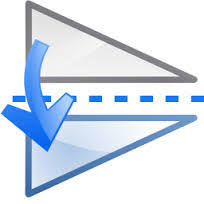

The above image flips across the x-axis.

In [ ]:
def show_images_rotate(df, read_region=(1780,1950)):
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join('../input/prostate-cancer-grade-assessment',"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        patch = np.array(patch)
        im_data = np.moveaxis(patch, -1, 0)  # make them channel first
        rotater = Flip(spatial_axis=1)
        new_img = rotater(im_data)
        
        ax[i//3, i%3].imshow(np.moveaxis(new_img.astype(int), 0, -1)) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'Rotated Transformed\n Gleason: {data_row[1][3]}')
    plt.show()
    
images = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']   
data_sample = train.loc[train.image_id.isin(images)]
show_images_rotate(data_sample)

**YOU ARE HERE:**
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 60%;" aria-valuenow="60" aria-valuemin="0" aria-valuemax="100">60%</div>
</div>

<h1 id="spapad"> <b>4. Spatial Padding</b></h1>

Spatial padding is used in Convolutional layers. Why? Well, convolutional layers often tend to lose pixels on the side of the image sometimes. With a small amount of Convolutional layers, it's fine but with many convolutional layers the pixel loss tends to add up over and over again and it can eventually spiral out of control.

One simple solution to this is to add some extra pixels around the borders so that even if we lose information in pixels it will not affect our model much. To keep it relatively useless besides being a dummy (in a metaphorical sense) we keep most of the values 0. The following image gives a good demo of padding:
![](https://d2l.ai/_images/conv-pad.svg)

In the above image we have a padded input, which is then processed into a kernel and then comes out as a 4 x 4.

Convolutional layers often pad with odd numbers such as 1, 3, 5 or 7. Thus, we can preserve the spatial dimensionality by padding with odd numbers. But don't think padding is only used in Convolutional layers, we can also use padding as a transform with MONAI.

In [ ]:
def show_images_rotate(df, read_region=(1780,1950)):
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join('../input/prostate-cancer-grade-assessment',"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        patch = np.array(patch)
        im_data = np.moveaxis(patch, -1, 0)  # make them channel first
        rotater = SpatialPad(spatial_size=(300, 300), mode='mean')
        new_img = rotater(im_data)
        
        ax[i//3, i%3].imshow(np.moveaxis(new_img.astype(int), 0, -1)) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title(f'Rotated Transformed\n Gleason: {data_row[1][3]}')
    plt.show()
    
images = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']   
data_sample = train.loc[train.image_id.isin(images)]
show_images_rotate(data_sample)

We can see dummy pixels being placed at the end (borders) of our images. Padding in action, baby!

**YOU ARE HERE:**
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 80%;" aria-valuenow="80" aria-valuemin="0" aria-valuemax="100">80%</div>
</div>

<h1 id="aptos">5. Experimental Method from APTOS</h1>
<hr>

I have read Neuron Engineer's notebook on APTOS and I have also read about a very useful preprocessing method used in that competition to great effect. I am not exactly sure of how well it will work but I am willing to try it out.

In [ ]:
import cv2
 
image = cv2.imread('../input/panda-resize-and-save-train-data/0005f7aaab2800f6170c399693a96917.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image = cv2.resize(image, (256, 256))
image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 256/10) ,-4 ,128) # the trick is to add this line
plt.imshow(image)
plt.title('Ben Graham Method\n Transformed image')
plt.show()


**YOU ARE HERE:**
<div class="progress">
  <div class="progress-bar" role="progressbar" style="width: 100%;" aria-valuenow="100" aria-valuemin="0" aria-valuemax="100">100%</div>
</div>

<h1 id="app1"> APPENDIX A: A list of useful resources and credits</h1>

## Credits to the libraries used:

+ **Pandas: https://pandas.pydata.org/ **
+ **Numpy: https://numpy.org/**
+ **Openslide: https://openslide.org/api/python/**
* **Matplotlib: https://matplotlib.org/**
+ **Monai: https://monai.readthedocs.io/en/latest/index.html**

## Useful resources

+ **https://www.urologyhealth.org/urologic-conditions/prostate-cancer**
+ **https://www.healthline.com/health/prostate-cancer**